# Clustering Smartphone Cases

## Preparation

In [105]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram

from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import adjusted_rand_score, silhouette_score

from src import akeneo, akeneo_clustering as ac, clustering, config

In [2]:
cache = akeneo.create_cache_from_env()

In [3]:
data_dir = config.dir_data / "clustering-results" / "1-cases"
data_dir.mkdir(parents=True, exist_ok=True)

In [4]:
family = "mobile_phone_cases"
channel = "default"
lang = "en_US"

### Products

In [5]:
products = ac.parse_products(
    cache,
    product_families=[family],
    attribute_types=ac.TYPES_NUMERICAL + ac.TYPES_CATEGORICAL + ac.TYPES_MULTI + ac.TYPES_TEXT,
)
products_multi_as_single = ac.transform_multi_to_single_cat(products)

n = len(products)

products_df = pd.DataFrame(products)
products_multi_as_single_df = pd.DataFrame(products_multi_as_single)

In [6]:
labels_want_generations = products_df["__categories__"].map(lambda x: x[-1].split("_")[0]).to_numpy()
k_generations = len(set(labels_want_generations))
pd.Series(labels_want_generations).value_counts(), f"k = {k_generations}"

(s20    45
 s21    31
 s22     4
 dtype: int64,
 'k = 3')

In [7]:
labels_want_models = products_df["__categories__"].map(lambda x: x[-1]).to_numpy()
k_models = len(set(labels_want_models))
pd.Series(labels_want_models).value_counts(), f"k = {k_models}"

(s20          18
 s20_plus     14
 s21          11
 s20_ultra    11
 s21_plus     10
 s21_fe        5
 s21_ultra     5
 s20_fe        2
 s22           2
 s22_ultra     1
 s22_plus      1
 dtype: int64,
 'k = 11')

### Attributes

In [8]:
tmp = {
    "code": [],
    "name": [],
    "type": [],
    "typeclass": [],
    "required": [],
    "non-null": [],
    "unique": [],
}

attr_req = list(filter(lambda f: f.code == family, cache.families))[0].attribute_requirements[channel]

for attr_code, attr in akeneo.Attribute.to_dict(cache.attributes).items():
    if attr_code not in products_df.columns:
        continue

    typeclass = (
        "numerical"
        if attr.type in ac.TYPES_NUMERICAL
        else "categorical"
        if attr.type in ac.TYPES_CATEGORICAL
        else "multi"
        if attr.type in ac.TYPES_MULTI
        else "string"
        if attr.type in ac.TYPES_TEXT
        else "unknown"
    )

    tmp["code"].append(attr_code)
    tmp["name"].append(attr.labels[lang])
    tmp["type"].append(attr.type)
    tmp["typeclass"].append(typeclass)
    tmp["required"].append(attr_code in attr_req)
    tmp["non-null"].append(products_df[attr_code].count())
    tmp["unique"].append(products_df[attr_code].drop_duplicates().count())

attr_df = pd.DataFrame(tmp)
attr_df.sort_values(["required", "non-null"], ascending=[False, False])

,code,name,type,typeclass,required,non-null,unique
17,icecat_brand_fixed,Brand,AttributeType.SELECT_SINGLE,categorical,True,80,4
19,icecat_name,Name,AttributeType.TEXT,string,True,80,58
20,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,80,80
21,icecat_title,Title,AttributeType.TEXT,string,True,80,80
11,icecat_8156,Brand compatibility,AttributeType.SELECT_SINGLE,categorical,True,79,1
18,icecat_description_short,Short Description,AttributeType.TEXT,string,True,77,59
9,icecat_6767,Maximum screen size,AttributeType.METRIC,numerical,True,76,7
13,icecat_8778,Case type,AttributeType.SELECT_SINGLE,categorical,True,76,3
14,icecat_898_fixed,Material,AttributeType.SELECT_MULTI,multi,True,57,10
12,icecat_8411,Surface coloration,AttributeType.SELECT_SINGLE,categorical,False,76,2


In [36]:
cols = ["code", "typeclass", "required", "non-null", "unique"]
attr_df[cols].groupby(["typeclass", "required"]).agg({
    "code": "count",
    "non-null": "mean",
    "unique": "mean",
}).reset_index().round(1)

,typeclass,required,code,non-null,unique
0,categorical,False,8,28.5,1.4
1,categorical,True,3,78.3,2.7
2,multi,True,1,57.0,10.0
3,numerical,False,5,19.4,9.2
4,numerical,True,1,76.0,7.0
5,string,True,4,79.2,69.2


### Clustering & Metrics

In [10]:
def calc_metrics(attr_codes, multi_as_single=False, attr_to_overweight: list[str] = None, factor = 2):
    dataset = (
        ac.dataset_from_records(products_df[attr_codes].to_dict("records"))
        if not multi_as_single
        else ac.dataset_from_records(products_multi_as_single_df[attr_codes].to_dict("records"))
    )
    prox_matrix = ac.calc_proximity_matrix(dataset)

    if attr_to_overweight is not None:
        dataset = ac.overweight_attributes(dataset, attr_to_overweight, factor)

    bik = clustering.BisectingKMeans(dataset, ac.Centroid, random_state=0)
    biks = [
        clustering.BisectingKMeans(dataset, ac.Centroid, random_state=i)
        for i in range(1, 11)
    ]

    stabilities = []
    for k in range(2, len(dataset) + 1):
        values = []
        for bikk in biks:
            values.append(
                adjusted_rand_score(
                    bik.labels_flat(k),
                    bikk.labels_flat(k),
                )
            )
        stabilities.append(np.array(values).mean())
    stabilities = np.array(stabilities)

    qualities = []
    for k in range(2, len(dataset)):
        qualities.append(silhouette_score(prox_matrix, bik.labels_flat(k), metric="precomputed"))
    qualities = np.array(qualities)

    return {
        "stabilities": stabilities,
        "qualities": qualities,
        "match_gen": adjusted_rand_score(labels_want_generations, bik.labels_flat(k_generations)),
        "match_mod": adjusted_rand_score(labels_want_models, bik.labels_flat(k_models)),
    }

In [11]:
def metrics_to_table(metric):
    matches = {
        "Match Generations": metric["match_gen"],
        "Match Models": metric["match_mod"],
    }
    result = {
        "Stability": metric["stabilities"].mean(),
        "Quality": metric["qualities"].mean(),
        "Match": np.array([v for _, v in matches.items()]).mean(),
    }
    return {
        "Mean": np.array([v for _, v in result.items()]).mean(),
        **result,
        **matches,
    }

## Clusterings

### Evaluate Multi-Categorical

In [12]:
attr_codes_mul = attr_df[attr_df["typeclass"] == "multi"]["code"].to_list()
attr_codes_str = attr_df[attr_df["typeclass"] == "string"]["code"].to_list()

attr_df[attr_df["code"].isin(attr_codes_mul+attr_codes_str)]

,code,name,type,typeclass,required,non-null,unique
14,icecat_898_fixed,Material,AttributeType.SELECT_MULTI,multi,True,57,10
18,icecat_description_short,Short Description,AttributeType.TEXT,string,True,77,59
19,icecat_name,Name,AttributeType.TEXT,string,True,80,58
20,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,80,80
21,icecat_title,Title,AttributeType.TEXT,string,True,80,80


In [13]:
def metrics_mul_make():
    return {
        "multi": calc_metrics(attr_codes_mul),
        "multi as single": calc_metrics(attr_codes_mul, True),
        "string as multi": calc_metrics(attr_codes_str),
        "string as single": calc_metrics(attr_codes_str, True),
    }
metrics_mul = config.load_or_create(data_dir / "metrics-mul.pkl", metrics_mul_make)

In [14]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_mul.items()
}).transpose().round(2)

,Mean,Stability,Quality,Match,Match Generations,Match Models
multi,0.39,0.71,0.44,0.03,0.02,0.04
multi as single,0.36,0.61,0.44,0.02,0.00,0.04
string as multi,0.47,0.87,0.20,0.35,0.54,0.16
string as single,0.27,0.64,0.15,0.01,0.03,-0.01


In [35]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_mul.items()
}).transpose()[["Stability", "Quality", "Match Generations", "Match Models"]].round(2)

,Stability,Quality,Match Generations,Match Models
multi,0.71,0.44,0.02,0.04
multi as single,0.61,0.44,0.00,0.04
string as multi,0.87,0.20,0.54,0.16
string as single,0.64,0.15,0.03,-0.01


### Evaluate Type Classes

In [15]:
tmp = ["numerical", "categorical", "multi", "string"]
attr_codes_types = {
    **{
        t: attr_df[attr_df["typeclass"]==t]["code"].to_list()
        for t in tmp
    },
    **{
        f"{t1[:3]}+{t2[:3]}": attr_df[attr_df["typeclass"].isin([t1, t2])]["code"].to_list()
        for t1, t2 in itertools.combinations(tmp, 2)
    },
    **{
        f"{t1[:3]}+{t2[:3]}+{t3[:3]}": attr_df[attr_df["typeclass"].isin([t1, t2, t3])]["code"].to_list()
        for t1, t2, t3 in itertools.combinations(tmp, 3)
    },
    "num+cat+mul+str": attr_df[attr_df["typeclass"].isin(tmp)]["code"].to_list(),
}
pd.DataFrame([(key, value) for key, value in attr_codes_types.items()])

,0,1
0,numerical,"[icecat_1464, icecat_1649, icecat_1650, icecat..."
1,categorical,"[icecat_15767, icecat_26241, icecat_27575_fixe..."
2,multi,[icecat_898_fixed]
3,string,"[icecat_description_short, icecat_name, icecat..."
4,num+cat,"[icecat_1464, icecat_15767, icecat_1649, iceca..."
5,num+mul,"[icecat_1464, icecat_1649, icecat_1650, icecat..."
6,num+str,"[icecat_1464, icecat_1649, icecat_1650, icecat..."
7,cat+mul,"[icecat_15767, icecat_26241, icecat_27575_fixe..."
8,cat+str,"[icecat_15767, icecat_26241, icecat_27575_fixe..."
9,mul+str,"[icecat_898_fixed, icecat_description_short, i..."


In [16]:
def metrics_types_make():
    return {
        key: calc_metrics(value)
        for key, value in attr_codes_types.items()
    }
metrics_types = config.load_or_create(data_dir / "metrics-types.pkl", metrics_types_make)

In [38]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_types.items()
}).transpose().round(2).style.highlight_max(color="lightgreen")

,Mean,Stability,Quality,Match,Match Generations,Match Models
numerical,0.530000,0.850000,0.430000,0.300000,0.150000,0.450000
categorical,0.310000,0.440000,0.390000,0.100000,0.080000,0.120000
multi,0.390000,0.710000,0.440000,0.030000,0.020000,0.040000
string,0.470000,0.870000,0.200000,0.350000,0.540000,0.160000
num+cat,0.520000,0.880000,0.520000,0.180000,0.090000,0.260000
num+mul,0.480000,0.780000,0.470000,0.200000,0.150000,0.260000
num+str,0.450000,0.860000,0.200000,0.300000,0.140000,0.460000
cat+mul,0.430000,0.790000,0.380000,0.110000,0.100000,0.130000
cat+str,0.440000,0.940000,0.270000,0.120000,0.100000,0.140000
mul+str,0.390000,0.850000,0.240000,0.080000,0.100000,0.060000


In [37]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_types.items()
}).transpose()[["Stability", "Quality", "Match Generations", "Match Models"]].round(2)

,Stability,Quality,Match Generations,Match Models
numerical,0.85,0.43,0.15,0.45
categorical,0.44,0.39,0.08,0.12
multi,0.71,0.44,0.02,0.04
string,0.87,0.20,0.54,0.16
num+cat,0.88,0.52,0.09,0.26
num+mul,0.78,0.47,0.15,0.26
num+str,0.86,0.20,0.14,0.46
cat+mul,0.79,0.38,0.10,0.13
cat+str,0.94,0.27,0.10,0.14
mul+str,0.85,0.24,0.10,0.06


<AxesSubplot:title={'center':'Quality'}, xlabel='k'>

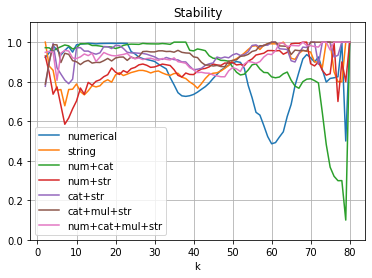

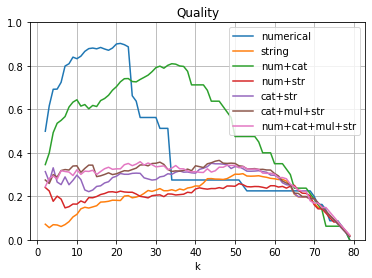

In [46]:
type_combis = ["numerical", "string", "num+cat", "num+str", "cat+str", "cat+mul+str", "num+cat+mul+str"]
pd.DataFrame({
    type_combi: metrics_types[type_combi]["stabilities"]
    for type_combi in type_combis
}, index=range(2, n+1)).plot.line(title="Stability", ylim=(0,1.1), xlabel="k", grid=True)
pd.DataFrame({
    type_combi: metrics_types[type_combi]["qualities"]
    for type_combi in type_combis
}, index=range(2, n)).plot.line( title="Quality", ylim=(0,1), xlabel="k", grid=True)

### Evaluate Attribute Selection

#### Required

In [18]:
def metrics_types_req_make():
    return {
        key: calc_metrics(list(filter(lambda a: a in attr_req, codes)))
        for key, codes in attr_codes_types.items()
    }
metrics_types_req = config.load_or_create(data_dir / "metrics-types-req.pkl", metrics_types_req_make)

In [19]:
pd.DataFrame({
    f"{key} req": metrics_to_table(values)
    for key, values in metrics_types_req.items()
}).transpose().round(2)

,Mean,Stability,Quality,Match,Match Generations,Match Models
numerical req,0.53,0.79,0.43,0.35,0.10,0.61
categorical req,0.30,0.45,0.40,0.04,0.04,0.04
multi req,0.39,0.71,0.44,0.03,0.02,0.04
string req,0.47,0.87,0.20,0.35,0.54,0.16
num+cat req,0.52,0.90,0.48,0.18,0.11,0.25
num+mul req,0.46,0.79,0.46,0.13,-0.01,0.28
num+str req,0.43,0.81,0.18,0.29,-0.01,0.60
cat+mul req,0.36,0.66,0.39,0.02,-0.00,0.04
cat+str req,0.41,0.89,0.25,0.09,0.01,0.16
mul+str req,0.39,0.85,0.24,0.08,0.10,0.06


In [50]:
selection = ["numerical", "categorical", "num+cat", "num+cat+mul+str"]
tmp = {}
for key in selection:
    tmp[f"{key}"] = metrics_to_table(metrics_types[key])
    tmp[f"{key} req"] = metrics_to_table(metrics_types_req[key])
pd.DataFrame(tmp).transpose().round(2)[["Stability", "Quality", "Match Generations", "Match Models"]]

,Stability,Quality,Match Generations,Match Models
numerical,0.85,0.43,0.15,0.45
numerical req,0.79,0.43,0.10,0.61
categorical,0.44,0.39,0.08,0.12
categorical req,0.45,0.40,0.04,0.04
num+cat,0.88,0.52,0.09,0.26
num+cat req,0.90,0.48,0.11,0.25
num+cat+mul+str,0.92,0.29,0.12,0.25
num+cat+mul+str req,0.80,0.26,0.13,0.15


<AxesSubplot:title={'center':'Quality'}, xlabel='k'>

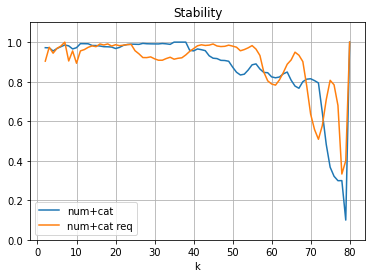

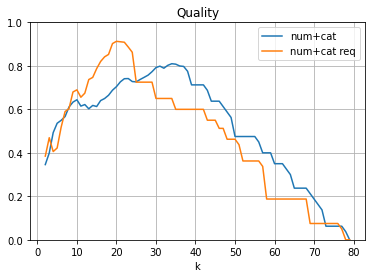

In [157]:
pd.DataFrame({
    "num+cat": metrics_types["num+cat"]["stabilities"],
    "num+cat req": metrics_types_req["num+cat"]["stabilities"],
}, index=range(2, n+1)).plot.line( title="Stability", ylim=(0,1.1), xlabel="k", grid=True)
pd.DataFrame({
    "num+cat": metrics_types["num+cat"]["qualities"],
    "num+cat req": metrics_types_req["num+cat"]["qualities"],
}, index=range(2, n)).plot.line( title="Quality", ylim=(0,1), xlabel="k", grid=True)

#### Custom Selection

In [20]:
def metrics_attr_make():
    return {
        attr_code: calc_metrics([attr_code])
        for attr_code in attr_df["code"]
    }
metrics_attr = config.load_or_create(data_dir / "metrics-attr.pkl", metrics_attr_make)

In [21]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_attr.items()
}).transpose().round(2).sort_values("Mean", ascending=False).style.highlight_max(color= "lightgreen")

,Mean,Stability,Quality,Match,Match Generations,Match Models
icecat_6767,0.530000,0.790000,0.430000,0.350000,0.100000,0.610000
icecat_summary_short,0.500000,0.600000,0.160000,0.740000,1.000000,0.490000
icecat_description_short,0.400000,0.730000,0.360000,0.120000,0.050000,0.180000
icecat_898_fixed,0.390000,0.710000,0.440000,0.030000,0.020000,0.040000
icecat_name,0.320000,0.580000,0.330000,0.040000,0.030000,0.040000
icecat_4860,0.310000,0.470000,0.250000,0.200000,0.310000,0.090000
icecat_1464,0.300000,0.560000,0.320000,0.030000,0.040000,0.020000
icecat_1649,0.300000,0.550000,0.340000,0.030000,0.040000,0.020000
icecat_94,0.290000,0.530000,0.330000,0.030000,0.040000,0.010000
icecat_title,0.290000,0.590000,0.150000,0.140000,0.050000,0.220000


In [22]:
attr_codes_high_impact = ["icecat_6767", "icecat_898_fixed", "icecat_summary_short"]
attr_df[attr_df["code"].isin(attr_codes_high_impact)]

,code,name,type,typeclass,required,non-null,unique
9,icecat_6767,Maximum screen size,AttributeType.METRIC,numerical,True,76,7
14,icecat_898_fixed,Material,AttributeType.SELECT_MULTI,multi,True,57,10
20,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,80,80


In [51]:
tmp = pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_attr.items()
}).transpose().round(2)
pd.merge(attr_df, tmp.reset_index().rename({"index": "code"}, axis=1), on="code").sort_values("Mean", ascending=False)

,code,name,type,typeclass,required,non-null,unique,Mean,Stability,Quality,Match,Match Generations,Match Models
9,icecat_6767,Maximum screen size,AttributeType.METRIC,numerical,True,76,7,0.53,0.79,0.43,0.35,0.10,0.61
20,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,80,80,0.50,0.60,0.16,0.74,1.00,0.49
18,icecat_description_short,Short Description,AttributeType.TEXT,string,True,77,59,0.40,0.73,0.36,0.12,0.05,0.18
14,icecat_898_fixed,Material,AttributeType.SELECT_MULTI,multi,True,57,10,0.39,0.71,0.44,0.03,0.02,0.04
19,icecat_name,Name,AttributeType.TEXT,string,True,80,58,0.32,0.58,0.33,0.04,0.03,0.04
8,icecat_4860,Desktop stand,AttributeType.BOOL,categorical,False,58,2,0.31,0.47,0.25,0.20,0.31,0.09
0,icecat_1464,Height,AttributeType.METRIC,numerical,False,24,11,0.30,0.56,0.32,0.03,0.04,0.02
2,icecat_1649,Width,AttributeType.METRIC,numerical,False,24,12,0.30,0.55,0.34,0.03,0.04,0.02
15,icecat_94,Weight,AttributeType.METRIC,numerical,False,24,11,0.29,0.53,0.33,0.03,0.04,0.01
21,icecat_title,Title,AttributeType.TEXT,string,True,80,80,0.29,0.59,0.15,0.14,0.05,0.22


In [68]:
cols = ["icecat_6767", "icecat_1464", "icecat_1649", "icecat_1650", "icecat_title", "icecat_summary_short", "icecat_brand_fixed"]
metrics_to_table(calc_metrics(cols))

{'Mean': 0.467722051457131,
 'Stability': 0.9486278379463374,
 'Quality': 0.24221491975423545,
 'Match': 0.21232339667082034,
 'Match Generations': 0.06987711704645333,
 'Match Models': 0.35476967629518735}

In [97]:
cols = ["icecat_1464", "icecat_1649", "icecat_1650", "icecat_title"]
metrics_to_table(calc_metrics(cols))

{'Mean': 0.41269160083168277,
 'Stability': 0.8208082846259329,
 'Quality': 0.22875721029990542,
 'Match': 0.1885093075692098,
 'Match Generations': 0.127334545949572,
 'Match Models': 0.24968406918884764}

In [96]:
cols = ["icecat_6767", "icecat_1464", "icecat_1649", "icecat_1650", "icecat_title", "icecat_brand_fixed"]
metrics_to_table(calc_metrics(cols))

{'Mean': 0.4721643240723234,
 'Stability': 0.922710475457335,
 'Quality': 0.29560211818437837,
 'Match': 0.1981803785752567,
 'Match Generations': 0.057566011240573936,
 'Match Models': 0.33879474590993947}

In [24]:
attr_codes_intuitive = ["icecat_6767", "icecat_title", "icecat_1464", "icecat_1649", "icecat_1650"]
attr_df[attr_df["code"].isin(attr_codes_intuitive)]

,code,name,type,typeclass,required,non-null,unique
0,icecat_1464,Height,AttributeType.METRIC,numerical,False,24,11
2,icecat_1649,Width,AttributeType.METRIC,numerical,False,24,12
3,icecat_1650,Depth,AttributeType.METRIC,numerical,False,24,11
9,icecat_6767,Maximum screen size,AttributeType.METRIC,numerical,True,76,7
21,icecat_title,Title,AttributeType.TEXT,string,True,80,80


In [25]:
def metrics_selection_make():
    return {
        "high impact": calc_metrics(attr_codes_high_impact),
        "intuitive": calc_metrics(attr_codes_intuitive),
    }
metrics_selection = config.load_or_create(data_dir / "metrics-selection.pkl", metrics_selection_make)

In [26]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_selection.items()
}).transpose().round(2)

,Mean,Stability,Quality,Match,Match Generations,Match Models
high impact,0.41,0.80,0.24,0.17,0.00,0.34
intuitive,0.47,0.86,0.25,0.30,0.13,0.46


### Evaluate Attribute Weight

In [27]:
def metrics_overweight_make():
    return {
        "all & intuitive x2": calc_metrics(attr_codes_types["num+cat+mul+str"], False, attr_codes_intuitive, 2),
        "all & intuitive x3": calc_metrics(attr_codes_types["num+cat+mul+str"], False, attr_codes_intuitive, 3),
        "num+cat & intuitive x2": calc_metrics(attr_codes_types["num+cat"], False, attr_codes_intuitive, 2),
        "num+cat & intuitive x3": calc_metrics(attr_codes_types["num+cat"], False, attr_codes_intuitive, 3),
        "num+cat+intuitive": calc_metrics(
            pd.Series(attr_codes_types["num+cat"]+attr_codes_intuitive).drop_duplicates().to_list()
        )
    }
metrics_overweight = config.load_or_create(data_dir / "metrics-overweight.pkl", metrics_overweight_make)

In [28]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_overweight.items()
}).transpose().round(2)

,Mean,Stability,Quality,Match,Match Generations,Match Models
all & intuitive x2,0.48,0.88,0.26,0.29,0.26,0.32
all & intuitive x3,0.43,0.87,0.23,0.19,0.09,0.29
num+cat & intuitive x2,0.55,0.87,0.50,0.29,0.26,0.31
num+cat & intuitive x3,0.55,0.86,0.50,0.29,0.26,0.31
num+cat+intuitive,0.49,0.93,0.36,0.17,0.09,0.25


## Winner

<AxesSubplot:title={'center':'Quality'}, xlabel='k'>

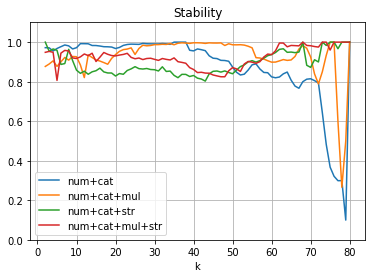

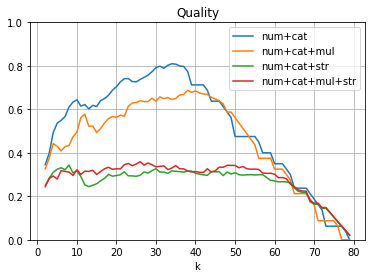

In [29]:
type_combis = ["num+cat", "num+cat+mul", "num+cat+str", "num+cat+mul+str"]
pd.DataFrame({
    type_combi: metrics_types[type_combi]["stabilities"]
    for type_combi in type_combis
}, index=range(2, n+1)).plot.line(title="Stability", ylim=(0,1.1), xlabel="k", grid=True)
pd.DataFrame({
    type_combi: metrics_types[type_combi]["qualities"]
    for type_combi in type_combis
}, index=range(2, n)).plot.line( title="Quality", ylim=(0,1), xlabel="k", grid=True)

## Aside

### Gruppieren nach Hersteller

In [141]:
labels_want_brand = products_df["icecat_brand_fixed"].to_list()
labels_want_brand_gen = labels_want_brand+labels_want_generations
labels_want_brand_mod = labels_want_brand+labels_want_models

In [143]:
k_brand = pd.Series(labels_want_brand).drop_duplicates().count()
k_brand_gen = pd.Series(labels_want_brand_gen).drop_duplicates().count()
k_brand_mod = pd.Series(labels_want_brand_mod).drop_duplicates().count()

In [146]:
def calc_metrics_brand(attr_codes: list[str]):
    dataset = ac.dataset_from_records(products_df[attr_codes].to_dict("records"))
    bik = clustering.BisectingKMeans(dataset, ac.Centroid, random_state=0)
    return {
        f"k={k_brand}": adjusted_rand_score(labels_want_brand, bik.labels_flat(k_brand)),
        f"k={k_brand_gen}": adjusted_rand_score(labels_want_brand_gen, bik.labels_flat(k_brand_gen)),
        f"k={k_brand_mod}": adjusted_rand_score(labels_want_brand_mod, bik.labels_flat(k_brand_mod)),
    }

In [145]:
def metrics_brand_make():
    return {
        key: calc_metrics_brand(codes)
        for key, codes in attr_codes_types.items()
    }
metrics_brand = config.load_or_create(data_dir / "metrics-brand.pkl", metrics_brand_make)

In [151]:
pd.DataFrame(metrics_brand).transpose().round(2)

,k=4,k=8,k=25
numerical,0.32,0.17,0.27
categorical,0.71,0.61,0.31
multi,0.26,0.35,0.16
string,0.04,0.43,0.48
num+cat,0.76,0.65,0.61
num+mul,0.17,0.34,0.46
num+str,0.34,0.44,0.60
cat+mul,0.75,0.57,0.28
cat+str,0.75,0.71,0.41
mul+str,0.44,0.29,0.29


In [152]:
calc_metrics_brand(list(filter(lambda a: a in attr_req, attr_codes_types["num+cat"])))

{'k=4': 0.5097666294126454,
 'k=8': 0.26570726775271636,
 'k=25': 0.5927088420085721}

## Sonstiges

In [129]:
dataset = ac.dataset_from_records(products_df[attr_codes_types["num+cat+mul+str"]].to_dict("records"))
bik = clustering.BisectingKMeans(dataset, ac.Centroid, random_state=0)
adjusted_rand_score(products_df["icecat_brand_fixed"], bik.labels_flat(4))

0.6947234378277932

In [130]:
dataset = ac.dataset_from_records(products_df[attr_codes_types["num+cat"]].to_dict("records"))
bik = clustering.BisectingKMeans(dataset, ac.Centroid, random_state=0)
adjusted_rand_score(products_df["icecat_brand_fixed"], bik.labels_flat(4))

0.7575744947456005

In [131]:
dend_labels = products_df["icecat_brand_fixed"].to_list()

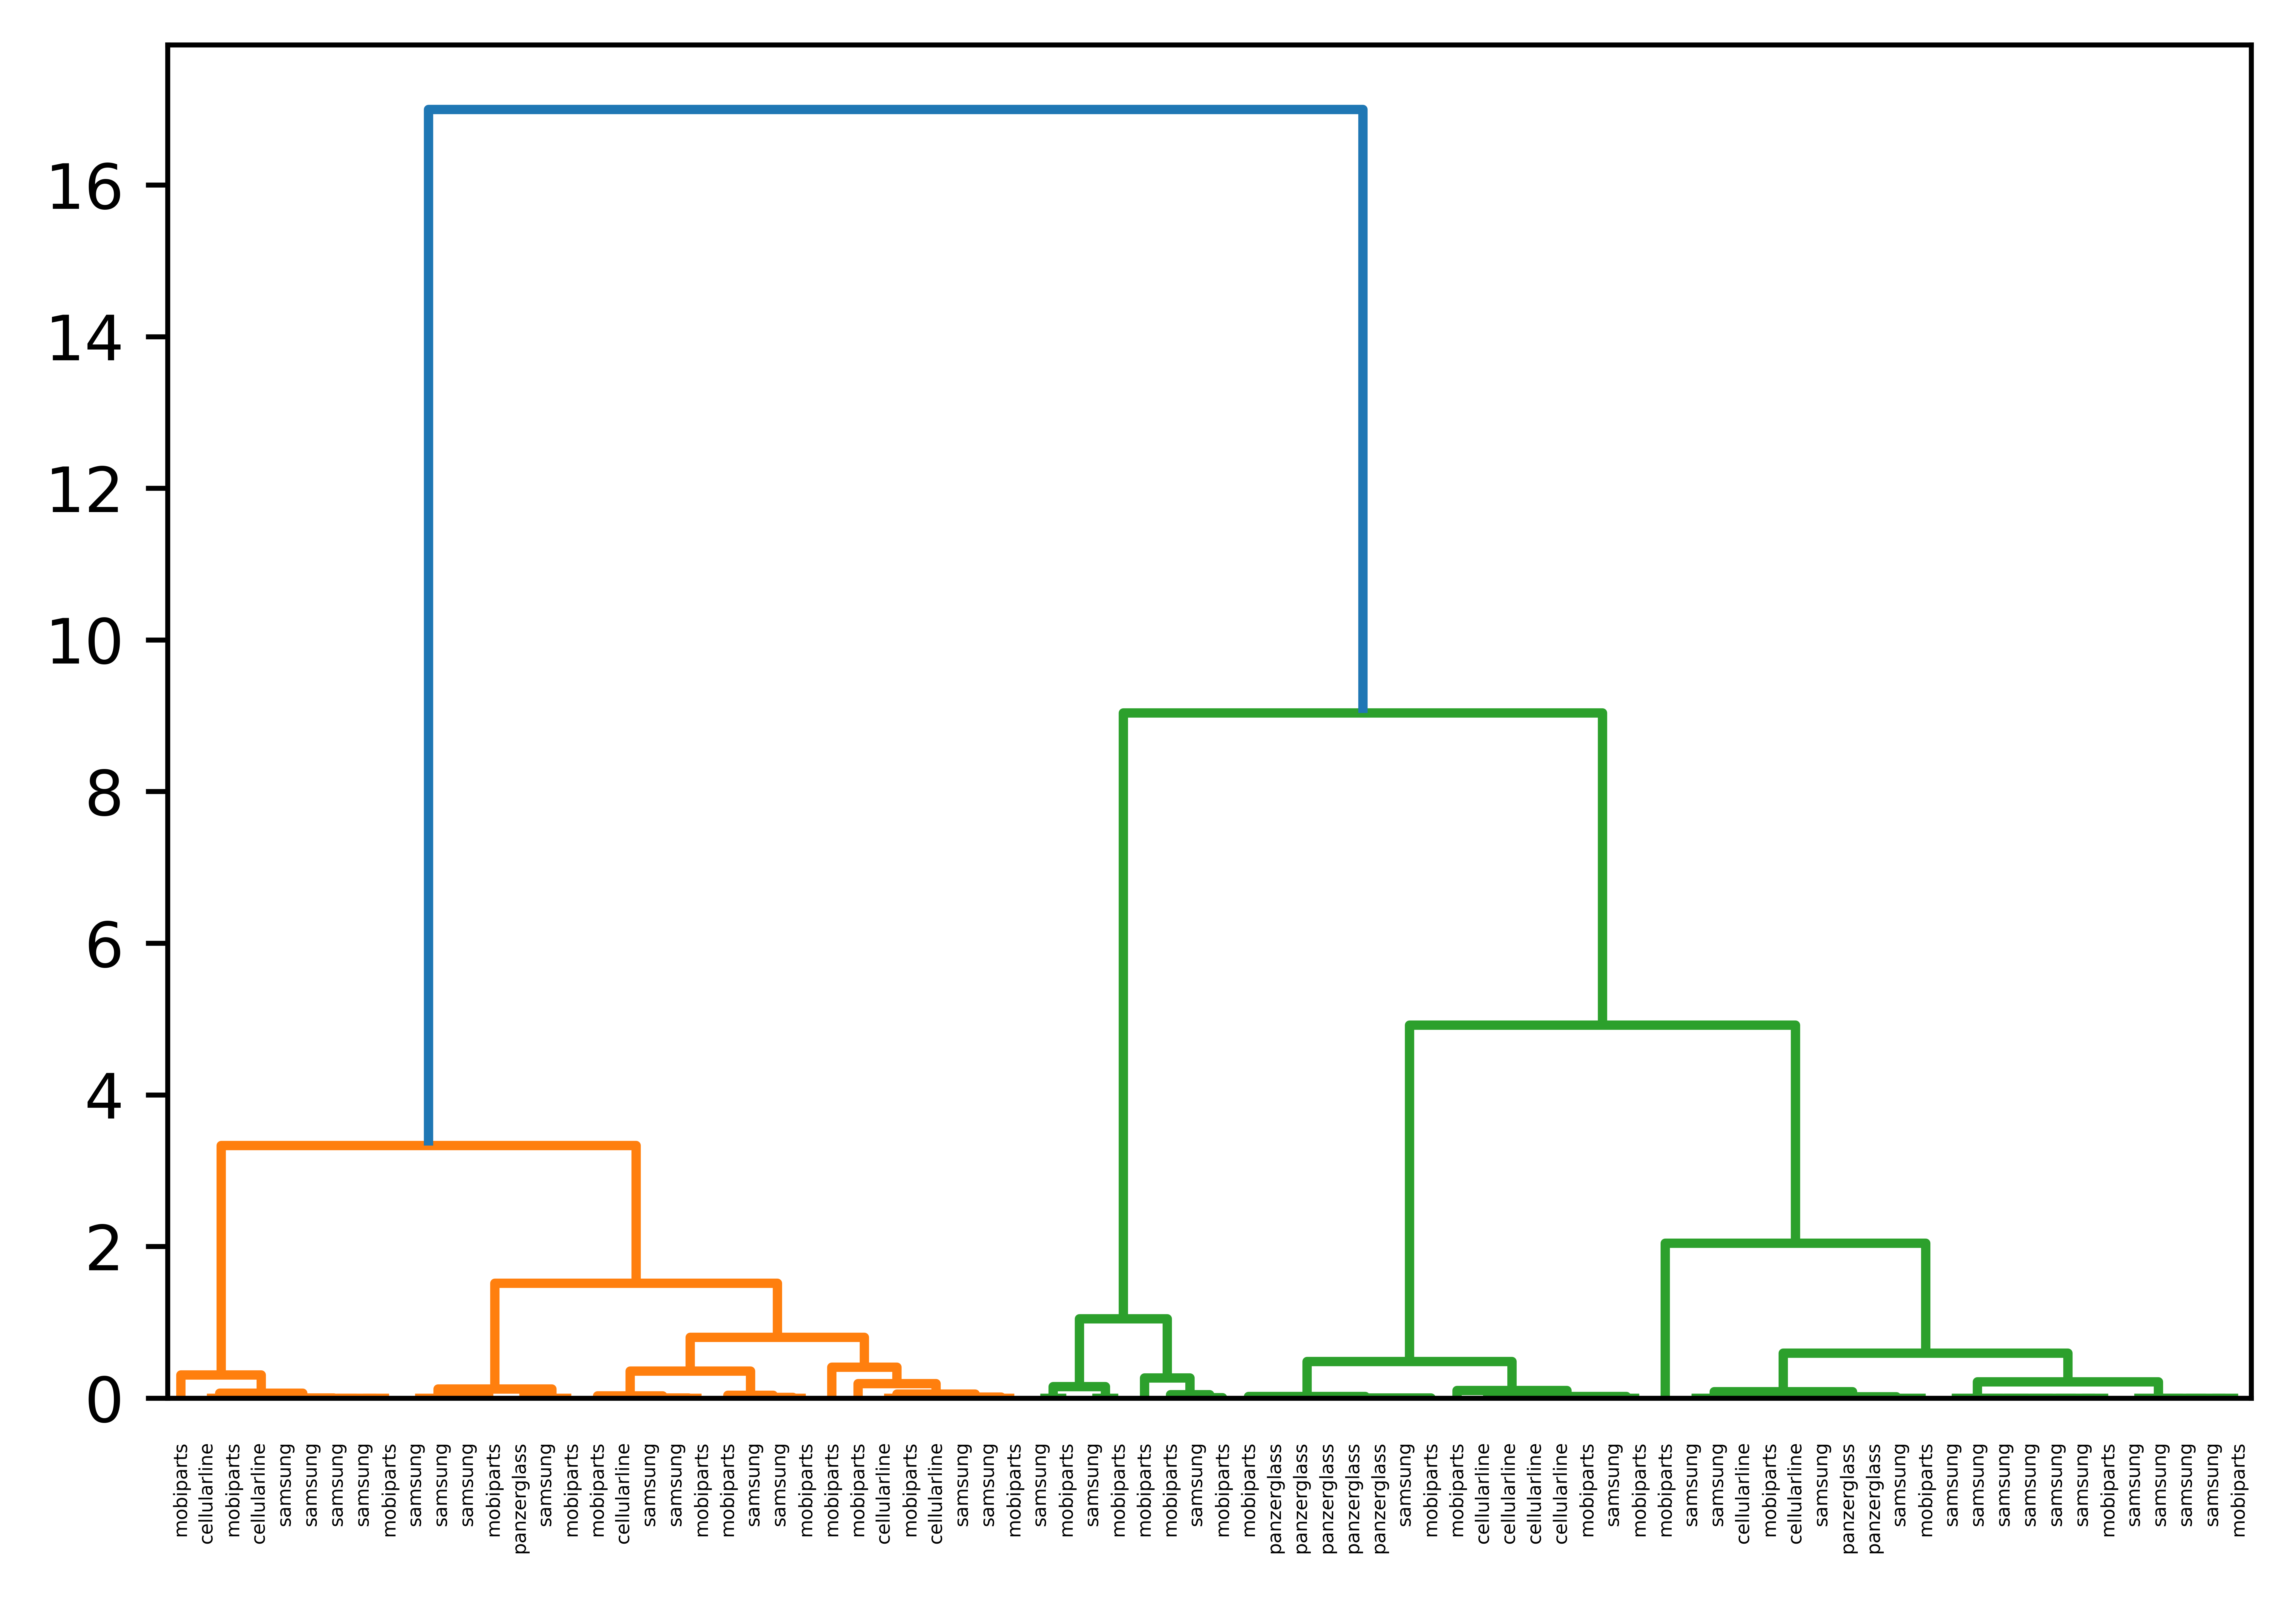

In [132]:
plt.figure(dpi=1500)
dendrogram(bik.dendrogram_matrix, labels=dend_labels, leaf_font_size=3)
plt.show()

In [100]:
def calc_mutual_information(attr_codes: list[str], k: int):
    dataset = ac.dataset_from_records(products_df[attr_codes].to_dict("records"))
    bik = clustering.BisectingKMeans(dataset, ac.Centroid, random_state=0)

    prod_num_df = products_multi_as_single_df[attr_codes].copy()
    for col in prod_num_df.columns:
        if not pd.api.types.is_numeric_dtype(prod_num_df[col]):
            prod_num_df[col] = pd.factorize(prod_num_df[col])[0]
    prod_num_df = prod_num_df.fillna(-1)

    for col in prod_num_df.columns:
        min = prod_num_df[col].min()
        max = prod_num_df[col].max()
        prod_num_df[col] = (prod_num_df[col] - min) / (max - min)

    cols = prod_num_df.columns.to_list()
    mi = mutual_info_classif(prod_num_df, bik.labels_flat(k))

    result = {}
    for i in range(len(cols)):
        result[cols[i]] = mi[i]

    return pd.Series(result, name="mi")
    # info_score = mutual_info_classif(prod_num_df, bik.labels_flat(k), random_state=0)
    # return pd.Series({
    #     attr_codes[i]: info_score[i]
    #     for i in range(len(attr_codes))
    # }).sort_values(ascending=False).to_dict()
chis = calc_mutual_information(attr_codes_types["num+cat+mul+str"], 3)

pd.merge(attr_df, chis, "outer", left_on="code", right_index=True).sort_values("mi", ascending=False)

,code,name,type,typeclass,required,non-null,unique,mi
17,icecat_brand_fixed,Brand,AttributeType.SELECT_SINGLE,categorical,True,80,4,0.875796
21,icecat_title,Title,AttributeType.TEXT,string,True,80,80,0.832269
19,icecat_name,Name,AttributeType.TEXT,string,True,80,58,0.830254
20,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,80,80,0.825007
18,icecat_description_short,Short Description,AttributeType.TEXT,string,True,77,59,0.784060
14,icecat_898_fixed,Material,AttributeType.SELECT_MULTI,multi,True,57,10,0.669936
0,icecat_1464,Height,AttributeType.METRIC,numerical,False,24,11,0.436083
3,icecat_1650,Depth,AttributeType.METRIC,numerical,False,24,11,0.383498
15,icecat_94,Weight,AttributeType.METRIC,numerical,False,24,11,0.382725
2,icecat_1649,Width,AttributeType.METRIC,numerical,False,24,12,0.368070


In [71]:
mut_info_df = pd.DataFrame([
    calc_mutual_information(attr_codes_types["num+cat+mul+str"], 3),
    calc_mutual_information(attr_codes_types["num+cat+mul+str"], 11),
], index=["k=3", "k=11"]).transpose()
mut_info_df

,k=3,k=11
icecat_brand_fixed,0.883899,1.418376
icecat_title,0.838340,1.835644
icecat_summary_short,0.830840,1.852401
icecat_name,0.815798,1.971627
icecat_description_short,0.778435,1.839614
icecat_898_fixed,0.668597,1.135420
icecat_1649,0.390715,0.822702
icecat_15767,0.350179,0.371630
icecat_1464,0.340526,0.879540
icecat_94,0.312050,0.712083


In [32]:
mut_info = calc_mutual_information(attr_codes_types["num+cat+mul+str"], 11)

In [33]:
pd.merge(attr_df, mut_info_df, left_on="code", right_index=True).sort_values("k=11", ascending=False)

,code,name,type,typeclass,required,non-null,unique,k=3,k=11
19,icecat_name,Name,AttributeType.TEXT,string,True,80,58,0.815798,1.939629
20,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,80,80,0.830840,1.834926
21,icecat_title,Title,AttributeType.TEXT,string,True,80,80,0.838340,1.820770
18,icecat_description_short,Short Description,AttributeType.TEXT,string,True,77,59,0.778435,1.791527
17,icecat_brand_fixed,Brand,AttributeType.SELECT_SINGLE,categorical,True,80,4,0.883899,1.403712
15,icecat_94,Weight,AttributeType.METRIC,numerical,False,24,11,0.312050,1.372739
3,icecat_1650,Depth,AttributeType.METRIC,numerical,False,24,11,0.288192,1.370526
5,icecat_27575_fixed,Closure,AttributeType.SELECT_SINGLE,categorical,False,27,2,0.158454,1.265083
0,icecat_1464,Height,AttributeType.METRIC,numerical,False,24,11,0.340526,1.234385
2,icecat_1649,Width,AttributeType.METRIC,numerical,False,24,12,0.390715,1.218585


In [47]:
rel_attr = ["icecat_name", "icecat_summary_short", "icecat_title", "icecat_brand_fixed", "icecat_898_fixed", "icecat_15767"]
pd.DataFrame([metrics_to_table(calc_metrics(rel_attr))])

,Mean,Stability,Quality,Match,Match Generations,Match Models
0,0.420666,0.890248,0.262798,0.108953,0.095363,0.122543


In [104]:
products_df["__categories__"].drop_duplicates()

0           [s20]
7      [s20_plus]
12       [s20_fe]
13          [s21]
19     [s21_plus]
25       [s21_fe]
35    [s20_ultra]
53    [s21_ultra]
76          [s22]
77    [s22_ultra]
79     [s22_plus]
Name: __categories__, dtype: object